In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [131]:
df = pd.read_csv('/content/Netflix-Subscriptions.csv')
df.head()

,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


In [132]:
df.duplicated().sum()

0

In [133]:
df.dtypes

,0
Time Period,object
Subscribers,int64


In [134]:
df = df.rename(columns = {'Time Period': 'Time_Period'})
df.head()

,Time_Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


In [135]:
df['Time_Period'] = pd.to_datetime(df['Time_Period'], format='%d/%m/%Y')
df.set_index('Time_Period', inplace=True)

In [136]:
df.head()

,Subscribers
Time_Period,
2013-04-01,34240000
2013-07-01,35640000
2013-10-01,38010000
2014-01-01,41430000
2014-04-01,46130000


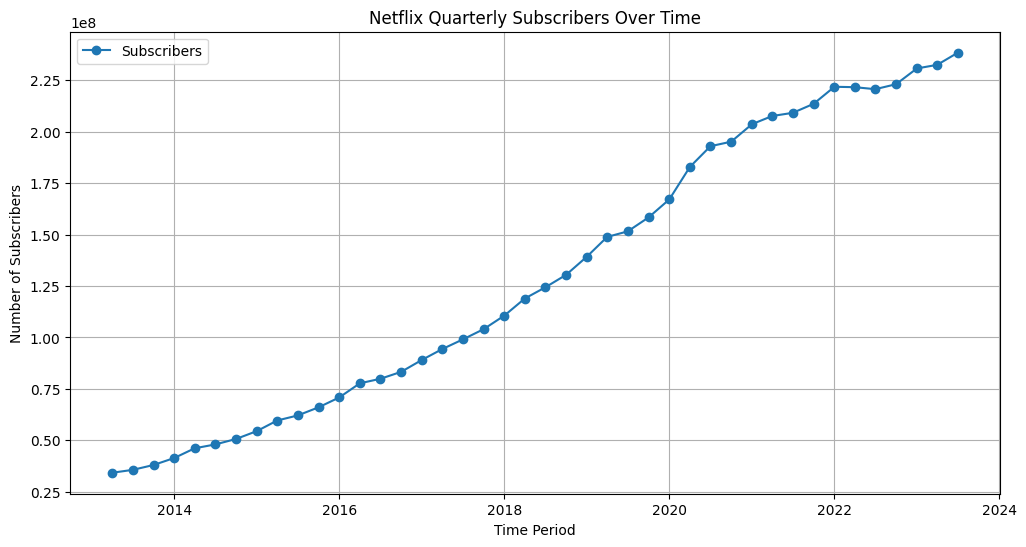

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(df['Subscribers'], marker='o', label='Subscribers')
plt.title('Netflix Quarterly Subscribers Over Time')
plt.xlabel('Time Period')
plt.ylabel('Number of Subscribers')
plt.legend()
plt.grid()
plt.show()

In [138]:
df['Subscribers'] = pd.to_numeric(df['Subscribers'])

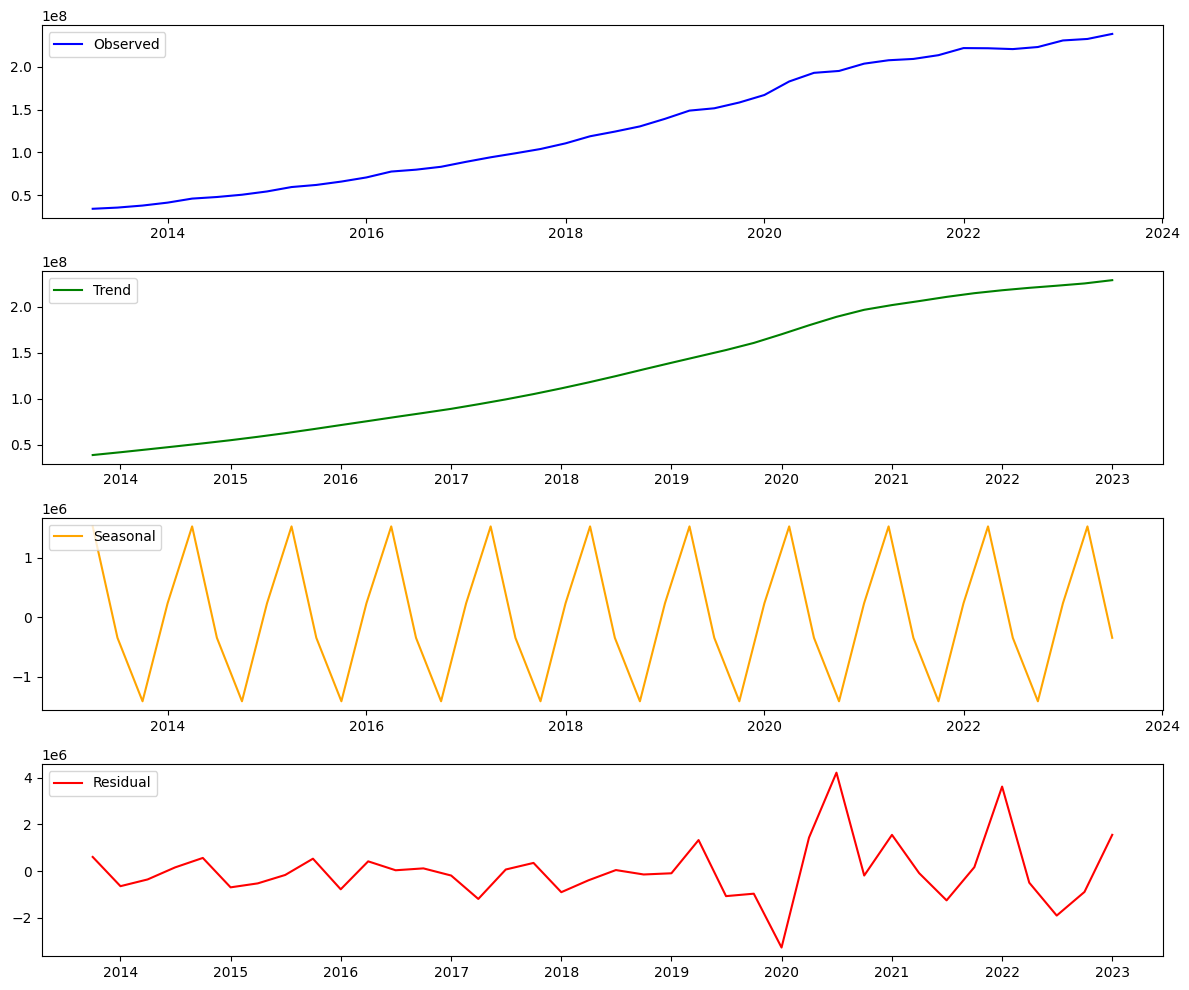

In [139]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Subscribers'], model='additive', period=4)


plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [140]:
from statsmodels.tsa.stattools import adfuller


def fullers_test(time_series):
  result = adfuller(time_series)
  print('ADF Statistic:', result[0])
  print('p-value:', result[1])

  if result[1] <= 0.05:
     print('The time series is stationary.')
  else:
     print('The time series is non-stationary.')

fullers_test(df['Subscribers'])

ADF Statistic: 0.20591078338329172
p-value: 0.972591170013349
The time series is non-stationary.


In [141]:
df['1st_Diff'] = df['Subscribers'] - df['Subscribers'].shift(1)
df.head()

,Subscribers,1st_Diff
Time_Period,,
2013-04-01,34240000,NaN
2013-07-01,35640000,1400000.00
2013-10-01,38010000,2370000.00
2014-01-01,41430000,3420000.00
2014-04-01,46130000,4700000.00


In [142]:
fullers_test(df['1st_Diff'].dropna())

ADF Statistic: -4.523088428253382
p-value: 0.00017858926729786176
The time series is stationary.


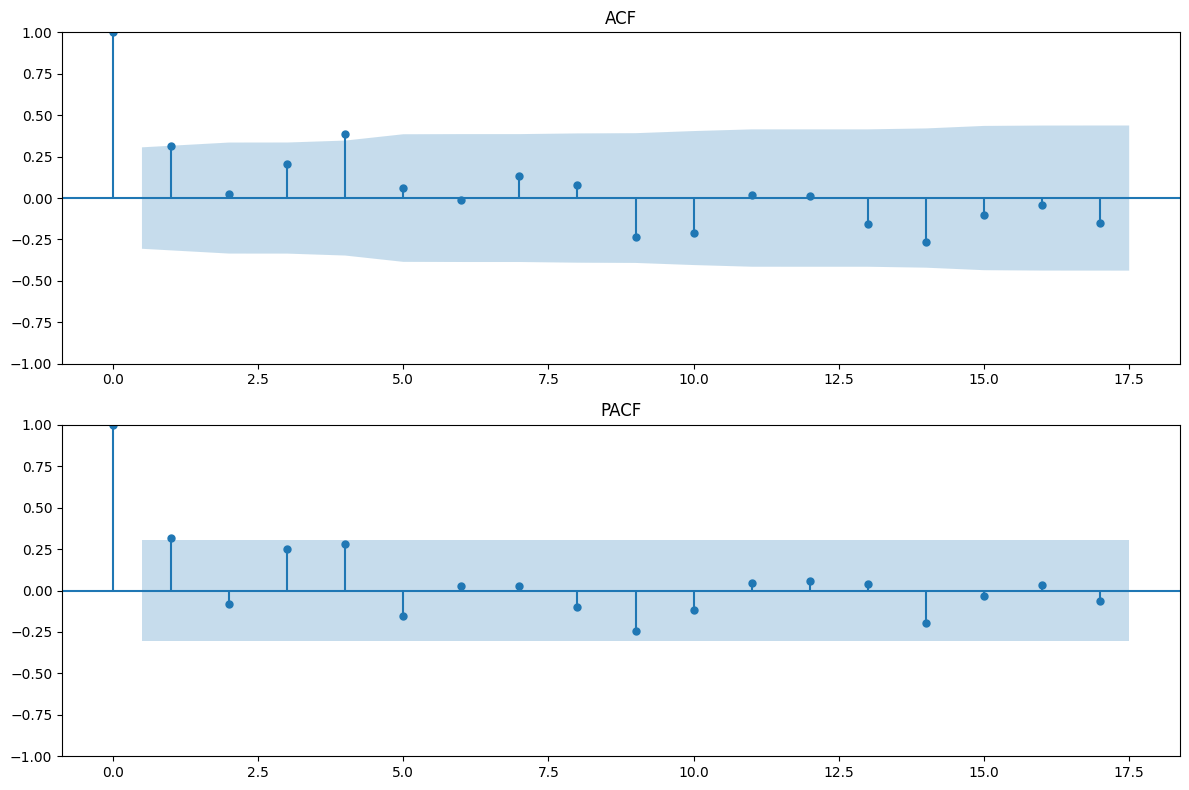

In [143]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(df['1st_Diff'].dropna(), ax=plt.gca())
plt.title('ACF')
plt.subplot(212)
plot_pacf(df['1st_Diff'].dropna(), ax=plt.gca())
plt.title('PACF')
plt.tight_layout()
plt.show()

In [144]:
df['subscribers_seasonal_diff'] = df['Subscribers'] - df['Subscribers'].shift(4)
fullers_test(df['subscribers_seasonal_diff'].dropna())

ADF Statistic: -2.073808313816979
p-value: 0.25517597073984344
The time series is non-stationary.


In [145]:
df['2nd_seasonal_diff'] = df['subscribers_seasonal_diff'] - df['subscribers_seasonal_diff'].shift(1)
fullers_test(df['2nd_seasonal_diff'].dropna())

ADF Statistic: -3.8876167413418985
p-value: 0.0021278949432505254
The time series is stationary.


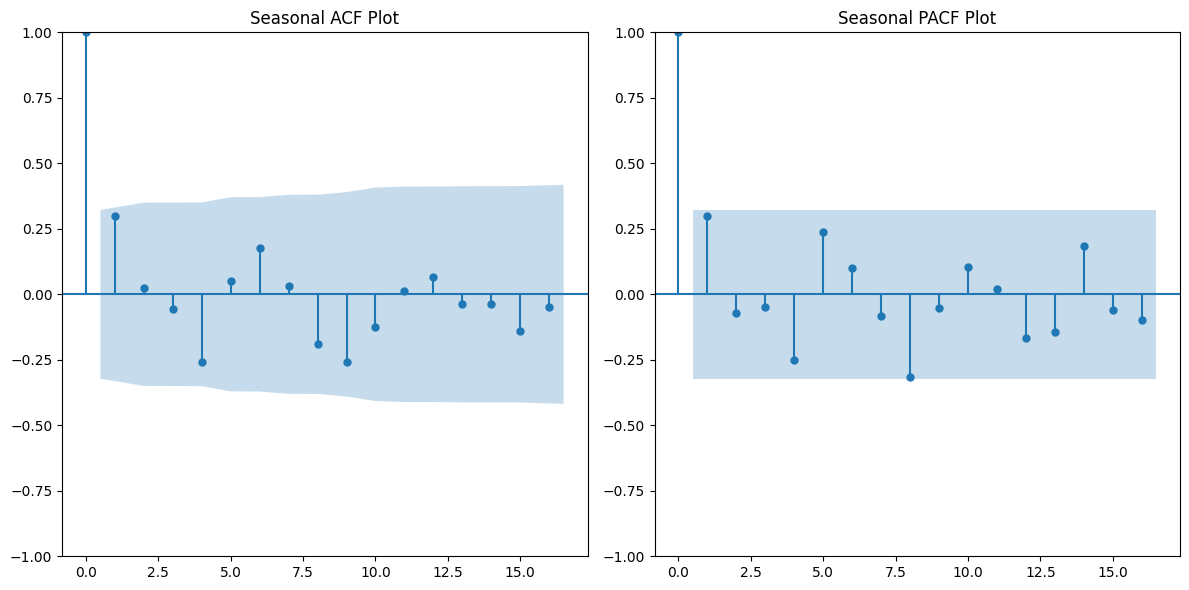

In [146]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['2nd_seasonal_diff'].dropna(), ax=plt.gca())
plt.title('Seasonal ACF Plot')
plt.subplot(122)
plot_pacf(df['2nd_seasonal_diff'].dropna(), ax=plt.gca())
plt.title('Seasonal PACF Plot')
plt.tight_layout()
plt.show()

In [147]:
df.head()

,Subscribers,1st_Diff,subscribers_seasonal_diff,2nd_seasonal_diff
Time_Period,,,,
2013-04-01,34240000,NaN,NaN,NaN
2013-07-01,35640000,1400000.00,NaN,NaN
2013-10-01,38010000,2370000.00,NaN,NaN
2014-01-01,41430000,3420000.00,NaN,NaN
2014-04-01,46130000,4700000.00,11890000.00,NaN


In [148]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

P = D = Q = range(0, 2)
m = 4
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(df['Subscribers'], order=param, seasonal_order=seasonal_param, trace=False)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
        except:
            continue

print('Best ARIMA parameters:', best_pdq)
print('Best seasonal parameters:', best_seasonal_pdq)

Best ARIMA parameters: (1, 2, 1)
Best seasonal parameters: (0, 1, 0, 4)


In [149]:
model_sarima = SARIMAX(df['Subscribers'], order=best_pdq, seasonal_order=best_seasonal_pdq)
results = model_sarima.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Subscribers   No. Observations:                   42
Model:             SARIMAX(1, 2, 1)x(0, 1, [], 4)   Log Likelihood                -594.186
Date:                            Tue, 07 Jan 2025   AIC                           1194.373
Time:                                    12:05:34   BIC                           1199.123
Sample:                                04-01-2013   HQIC                          1196.031
                                     - 07-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3514      0.219      1.608      0.108      -0.077       0.780
ma.L1         -0.9622      0.171   

In [150]:
import pmdarima as pm

auto_arima_model = pm.auto_arima(df['Subscribers'], seasonal=True, m=4, trace=True, suppress_warnings=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1347.498, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1350.227, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1349.713, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1396.725, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=1348.656, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=1347.732, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=1349.701, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=1353.918, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=1349.462, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1351.536, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4] intercept
Total fit time: 2.382 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
M

In [151]:
model = SARIMAX(df['Subscribers'], order=(0,1,0), seasonal_order=(0,0,0,4), trend='c')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -671.749
Date:                Tue, 07 Jan 2025   AIC                           1347.498
Time:                        12:05:36   BIC                           1350.925
Sample:                    04-01-2013   HQIC                          1348.746
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.979e+06   5.57e+05      8.942      0.000    3.89e+06    6.07e+06
sigma2      9.968e+12   1.88e+12      5.316      0.000    6.29e+12    1.36e+13
Ljung-Box (L1) (Q):                   4.36   Jarque-

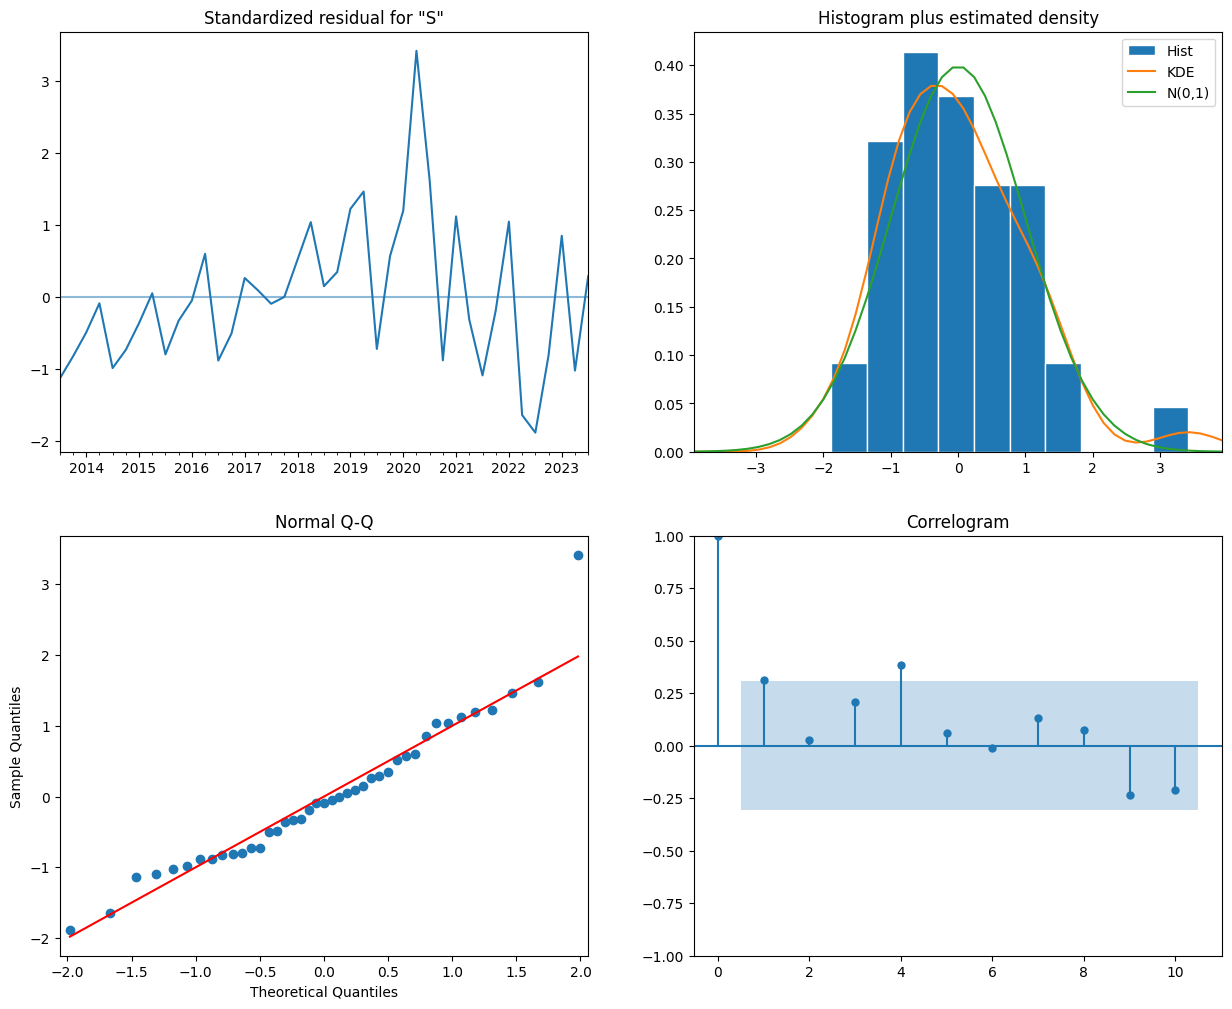

In [152]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [153]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = results.resid
lb_test = acorr_ljungbox(residuals, lags=10)

print(lb_test)

    lb_stat  lb_pvalue
1      0.02       0.90
2      0.17       0.92
3      0.20       0.98
4      0.82       0.94
5      1.03       0.96
6      1.31       0.97
7      1.31       0.99
8      1.32       1.00
9      2.67       0.98
10     3.44       0.97


In [154]:
len(df)

42

In [155]:
df.tail()

,Subscribers,1st_Diff,subscribers_seasonal_diff,2nd_seasonal_diff
Time_Period,,,,
2022-07-01,220670000,-970000.00,11490000.00,-2510000.00
2022-10-01,223090000,2420000.00,9530000.00,-1960000.00
2023-01-01,230750000,7660000.00,8910000.00,-620000.00
2023-04-01,232500000,1750000.00,10860000.00,1950000.00
2023-07-01,238390000,5890000.00,17720000.00,6860000.00


In [156]:
# Forecast for the next 5 quarters
forecast_steps = 5
forecast = results.forecast(steps=forecast_steps)

print(forecast)

2023-10-01   243369268.29
2024-01-01   248348536.59
2024-04-01   253327804.88
2024-07-01   258307073.17
2024-10-01   263286341.46
Freq: QS-OCT, Name: predicted_mean, dtype: float64


In [157]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='QS')[1:]
forecast_df = pd.DataFrame({'Subscribers': forecast}, index=future_dates)
combined_df = pd.concat([df, forecast_df])
combined_df.tail()

,Subscribers,1st_Diff,subscribers_seasonal_diff,2nd_seasonal_diff
2023-10-01,243369268.29,NaN,NaN,NaN
2024-01-01,248348536.59,NaN,NaN,NaN
2024-04-01,253327804.88,NaN,NaN,NaN
2024-07-01,258307073.17,NaN,NaN,NaN
2024-10-01,263286341.46,NaN,NaN,NaN


In [158]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [159]:
df.tail()

,Subscribers,1st_Diff,subscribers_seasonal_diff,2nd_seasonal_diff
Time_Period,,,,
2022-07-01,220670000,-970000.00,11490000.00,-2510000.00
2022-10-01,223090000,2420000.00,9530000.00,-1960000.00
2023-01-01,230750000,7660000.00,8910000.00,-620000.00
2023-04-01,232500000,1750000.00,10860000.00,1950000.00
2023-07-01,238390000,5890000.00,17720000.00,6860000.00


In [160]:
forecast_df

,Subscribers
2023-10-01,243369268.29
2024-01-01,248348536.59
2024-04-01,253327804.88
2024-07-01,258307073.17
2024-10-01,263286341.46


In [161]:
combined_df.tail()

,Subscribers,1st_Diff,subscribers_seasonal_diff,2nd_seasonal_diff
2023-10-01,243369268.29,NaN,NaN,NaN
2024-01-01,248348536.59,NaN,NaN,NaN
2024-04-01,253327804.88,NaN,NaN,NaN
2024-07-01,258307073.17,NaN,NaN,NaN
2024-10-01,263286341.46,NaN,NaN,NaN


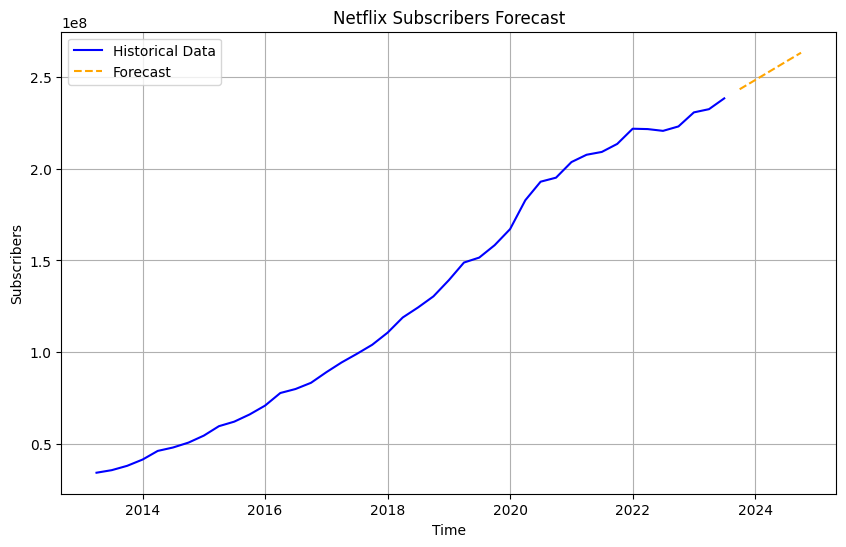

In [162]:
plt.figure(figsize=(10, 6))
plt.plot(df['Subscribers'], label='Historical Data', color='blue')
plt.plot(forecast_df['Subscribers'], label='Forecast', color='orange', linestyle='dashed')
plt.legend()
plt.title('Netflix Subscribers Forecast')
plt.xlabel('Time')
plt.ylabel('Subscribers')
plt.grid()
plt.show()